In [796]:
import pandas as pd
pd.set_option('max_colwidth', 15000)
pd.set_option('display.max_columns', 400)
import numpy as np
import spacy
import contextualSpellCheck
import nltk
import re
import ftfy
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data_compiled_raw.csv").iloc[:,1:]

In [211]:
# Spell check ------- done manually, maybe will try to see if word2vec can do this (or can do regex to at least get in$ to ing)
# FTFY package converting ain't into aingt ----- this matter is resolved
# slang (pronoun) dictionary - Jay-Z, Ms. Jackson, (consider dropping named entities)
# named entity recognition
# Cosine similarity to remove (almost) duplicates on Chorus
# Remove verbs, keep adjectives and nouns
# Drop immortal technique + 4487 Common? or spanish
# DO BIGRAMS & hyphens

### Data cleaning and setup

In [238]:
df.loc[df.lyrics.str.contains("1.", case=False) & (df.lyrics.str.contains(",published", case=False) |df.lyrics.str.contains("published", case=False))]

to_drop_album_info = ['''1. Pre feat. SK La'Flare,Written by Thebe Kgositsile and Shakeir Duarte,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Nextlevel (BMI),Produced by Michael "Uzi" Uzowuru,Engineered by Om'Mas Keith @ Whitelines Laboratories (Hollywood, CA),All Instruments: Michael "Uzi" Uzowuru/Om'Mas Keith,2. Burgundy feat. Vince Staples,Written by Thebe Kgositsile, Pharrell Williams and Chad Hugo,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/EMI April Music Inc. o/b/o itself and More Water From Nazareth (ASCAP)/Raynchaser Music, admin. by Universal Music - Careers (BMI),Produced by The Neptunes,Recorded by Mike Larson for i am OTHER Entertainment at Glenwood Place Studios (Burbank, CA),Assistant: Cesar Loza,Additional Vocals: Vince Staples,3. 20 Wave Caps feat. Domo Genesis,Written by Thebe Kgositsile and Dominique Cole,Published by: randomblackdude Publishing LLC and Chill Bro Music, admin by Sony ATV/Songs LLC (BMI),Produced by Samiyam for Good Food,Produced by randomblackdude,Recorded by Alchemist @ The Chemistry Lab, Santa Monica, CA,4. Sunday feat. Frank Ocean,Written by Thebe Kgositsile and Christopher Breaux,Published by: randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI) Heavens Research LP admin. by BMG Chrysalis Music Publishing (BMI),Produced by randomblackdude and Frank Ocean,Recorded by Jeff Ellis & Malay Ho at Two Thousand One (Hollywood, CA),Keys: Frank Ocean,5. Hive feat. Vince Staples & Casey Veggies,Written by Thebe Kgositsile, Vince Staples and Casey Jones,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Vince Staples/Casey Veggies Publishing (BMI),Produced by randomblackdude & Matt Martians of The Super 3,Engineered by Syd at Flagstaff (Marina Del Rey, CA),6. Chum,Written by Thebe Kgositsile, Taiwo Hassan, Kehinde Hassan and Chad Hugo,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Get Yo Mash Butt Ova Here Music (BMI) and Bacon Egg Sandwich Music, admin. by WB Music Corp. (ASCAP)/Raynchaser Music, admin. by Universal Music Careers (BMI),Produced by randomblackdude and Christian Rich for Good Luck Chuck,Recorded by Julian Prindle at Paramount Recording Studios, Hollywood, CA,Outro produced by Christian Rich for Good Luck Chuck, Chad Hugo of the Neptunes, and randomblackdude,Trumpet: Chad Hugo,7. Sasquatch feat. Tyler the Creator,Written by Thebe Kgositsile and Tyler Okonma,Published by randomblackdude Publishing LLC and Golf Wang Steak Sauce, admin. by Sony/ATV Songs LLC (BMI),Produced by Tyler, The Creator,Recorded by Vic Wainstein at Paramount Recording Studios, Hollywood, CA,8. Centurion feat. Vince Staples,Written by Thebe Kgositsile, Taiwo Hassan, Kehinde Hassan, Vince Staples, Holger Czukay, Irmin Schmidt, Jaki Liebezeit, Michael Karoli and David Axelrod,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Get Yo Mash Butt Ova Here Music (BMI) and Bacon Egg Sandwich Music, admin. by WB Music Corp. (ASCAP)/Vince Staples/The Royalty Network (ASCAP)/BMG Chrysalis Music Publishing (ASCAP),Produced by Christian Rich for Good Luck Chuck,Recorded at Paramount Recording Studios, Los Angeles, CA,Contains a sample from "Soup", as performed by Can,Written by Holger Czukay, Irmin Schmidt, Jaki Liebzeit, and Michael Karol,Published by The Royalty Network (ASCAP/BMI),Used courtesy of Spoon Records under license from Mute Records UK,Contains a sample from "A Divine Image", as performed by David Axelrod,Written by David Axelrod. Published by BMG Chrysalis Music (ASCAP/BMI),Used courtesy of Capitol Records-EMI under license from EMI Music Group,9. 523,Written by Thebe Kgositsile,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI),Produced by randomblackdude,Recording studio: my house - the media station,10. Uncle Al,Written by Thebe Kgositsile,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI),Produced by randomblackdude,Recording studio: my house - the media station,11. Guild feat. Mac Miller,Written by Thebe Kgositsile and Malcolm McCormick,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Blue Slide Park Music (BMI),Produced by randomblackdude,Engineered by Josh Berg at The Sanctuary (Narnia, CA),12. Molasses feat. RZA,Written by Thebe Kgositsile, Lennie Hibbert and Clement Dodd,Published by randomblackdude Publishing LLC, admin. by Sony/ATV Songs LLC (BMI)/Ramecca Music, admin. by Universal Music-Careers (BMI)/Happy Valley Music o/b/o JamRec Music (BMI),Produced by RZA,Co-produced by Christian Rich for Good Luck Chuck,Recorded at Encore Studios (Burbank, CA),Contains a sample from "Rose Len", as performed by Lennie Hibbert,Written by Lennie Hibbert & Clement Dodd,Published by Happy Valley Music o/b/o JAMREC Music (BMI),Used courtesy of Studio One/New Rounder LLC, under license from Souljazz Records Ltd,13. Whoa feat. Tyler the Creator,Written by Thebe Kgositsile and Tyler Okonma,Published by randomblackdude Publishing LLC and Golf Wang Steak Sauce, admin. by Sony/ATV Songs LLC (BMI),Produced by Tyler, The Creator,Recorded by Vic Wainstein at Paramount Recording Studios (Hollywood, CA),14. Hoarse,Written by Thebe Kgositsile and Christopher Breaux,Published by randomblackdude Publising LLC, admin. by Sony/ATV Songs LLC (BMI)/Heavens Research LP, admin. by BMG Chrysalis Music Publishing (BMI),Produced by BADBADNOTGOOD,Recorded by Vic Wainstein at Paramount Recording Studios (Hollywood, CA),Additional vocals: Frank Ocean,15. Knight feat. Domo Genesis,Written by Thebe Kgositsile, Dominique Cole, Paul Willis and Tyrone Douglas,Published by randomblackdude Publishing LLC and Chill Bro Music, admin. by Sony/ATV Songs LLC (BMI) / Get Yo Mash Butt Ova Here Music and Bacon Egg Sandwich Music, admin. by WB Music Corp. (ASCAP) / Bridgeport Music Inc. (BMI),Produced by Christian Rich for Good Luck Chuck,Recorded at Paramount Recording Studios (Hollywood, CA),Additional keys: Chad Hugo and Ron Gilmore,Contains a sample from "I've Changed" as performed by The Magictones,Written by Paul Willis and Tyrone Douglas,Published by Bridgeport Music Inc. (BMI),Used courtesy of Bridgeport Westbound Records, by arrangement with Fine Gold Music,Hold up, hey now, the beast in me,Is no longer sleeping, it wants to eat MC's,So I let 'em free, let 'em feed peacefully,Until he cease, now a beast must drop feces,But I never let it free fall, I catch it and spit it,I kick shit that blows whole districts into tidbits,With pen in fist, I take tallys, of these scrimmages,Can't call it game, my juego wicked as witches is,The kid spits fuego sicker than syphilis,So sister and brothers grab a shovel start digging this,Matter fact, grab a Nikon and picture this,An icon with no assistance and no assist in this,Reminisce the number one plus twenty three,My days are sunny with steeze sweeter than honey bees,Waters are muddy, I'm cunning running from nothing be,Now I'm fucking muffin mothafuckas ain't touch me, Tracklist: 1. Huey,2. Mantra,3. Faucet,4. Grief,5. Off Top,6. Grown Ups (Feat. Dash),7. AM // Radio (Feat. Wiki),8. Inside,9. Dna (Feat. Na’kel),10. Wool (Feat. Vince Staples),Cover Art:,Uh, uh''',\
                     '''1. KING PUSH (T. THORNTON, K. WEST, S. SARTOR) (BMI/SEBASTIAN SARTOR PUBLISHING DESIGNEE) PRODUCED BY KANYE WEST AND SEBASTIAN SARTOR RECORDED BY PAUL BAILEY AT THOMAS CROWN STUDIOS, VIRGINIA BEACH VA MIXED BY NOAH GOLDSTEIN AT NO NAME STUDIO, NYC ADDITIONAL MUSIC BY KEN LEWIS AND BRENT KOLATALO,2. NUMBERS ON THE BOARDS (T. THORNTON, D. CANNON, K. WEST, C. NJAPA, B. SIGLER, S. CARTER, C. MARTIN, A KING, J. MATTHEWS) (BMI/ASCAP) PRODUCED BY DON CANNON FOR CANNON MUSIC, LLC AND KANYE WEST. ADDITIONAL PRODUCTION BY CHARLES M. NJAPA PKA 88-KEYS RECORDED BY ANTHONY KILHOFFER AT STUDIO SEINE, PARIS AND DON CANNON AT MEAN STREET STUDIOS, AT LANTA, GA MIXED BY NOAH GOLDSTEIN AT NO NAME HOTEL, PARIS PRODUCTION COORDINATION FOR CANNON MUSIC BY KEKE AND AMY FOR COOKIES AND MILK. CONTAINS SAMPLES OF “SHAKE YOUR BOOTY” PERFORMED BY BUNNY SIGLER, USED COURTESY OF SONY MUSIC ENTERTAINMENT. WRITTEN BY B. SIGLER AND PUBLISHED BY WARNER-TAMERLANE PUBLISHING CORP. (BMI). USED BY PERMISSION. ALL RIGHTS RESERVED. CONTAINS SAMPLES OF THE RECORDING “INTRO/A MILLION AND ONE QUESTIONS/RHYME NO MORE” PERFORMED BY JAY Z. COURTESY OF THE ISLAND DEF JAM MUSIC GROUP, UNDER LICENSE FROM UNIVERSAL MUSIC ENTERPRISES. WRITTEN BY S. CARTER AND C. MARTIN, PUBLISHED BY EMI BLACKWOOD MUSIC INC. (BMI)/EMI APRIL MUSIC INC. (ASCAP)/LIL LU LU PUBLISHING (ASCAP)/GIFTED PEARL MUSIC INC. (ASCAP). USED BY PERMISSION. ALL RIGHTS RESERVED CONTAINS SAMPLES OF “POTS AND PANS” PERFORMED BY LUKE VIBERT, USED COURTESY OF UNIVERSAL MUSIC PUBLISHING LIMITED. WRITTEN BY A. KING AND J MATTHEWS, PUBLISHED BY UNIVERSAL MUSIC PUBLISHING LIMITED,3. SWEET SERENADE FEAT. CHRIS BROWN (T THORNTON, K. DEAN, K. WEST, C. BROWN)(BMI/SESAC) PRODUCED BY SWIZZ BEATZ FOR SWIZZ BEATZ PRODUCTIONS, INC. AND MONSTER MUSIC GROUP ADDITIONAL PRODUCTION BY KANYE WEST RECORDED BY PAUL BAILEY AT THOMAS CROWN STUDIOS, VIRGINIA BEACH, VA MIXED BY ANTHONY KILHOFFER AT THE SPOT STUDIOS, LOS ANGELES, CA MIX ASSISTED BY KYLE ROSS CHRIS BROWN APPEARS COURTESY OF RCA RECORDS,4. HOLD ON FEAT. RICK ROSS (T. THORNTON, K. WEST, R. BIRCHARD, W. ROBERTS, M. HAWKINS, J. HUTSON, L HUTSON, J. REAVES, W. NORMAN) (BMI/ASCAP) PRODUCED BY KANYE WEST AND HUDSON MOHAWKE RECORDED BY NOAH GOLDSTEIN AT ISLAND SOUND STUDIOS, HAWAII MIXED BY NOAH GOLDSTEIN AT NO NAME STUDIO, NYC KEYS: DARHYL “DJ” CAMPER CONTAINS SAMPLES OF “GHET-TO-FUNK” PERFORMED BY DURALCHA, USED COURTESY OF THE NUMERO GROUP. WRITTEN BY W. NORMAN, PUBLISHED BY DUST INDEX (BMI),5. SUICIDE FEAT. AB-LIVA (T. THORNTON, P. WILLIAMS, R. EAST) (BMI/ASCAP) PRODUCED BY PHARRELL WILLIAMS RECORDED BY MIKE LARSON FOR I AM OTHER ENTERTAINMENT AND PAUL BAILEY RECORDED AT CIRCLE HOUSE STUDIOS, MIAMI FL AND THOMAS CROWN STUDIOS, VIRGINIA BEACH, VA ASSISTED BY MATTHEW DESRAMEAUX AND GENNARO SCHIANO DIGITAL ARRANGEMENT AND EDITING BY MIKE LARSON MIXED BY MIKE LARSON FOR I AM OTHER ENTERTAINMENT AT SETAI RECORDING STUDIO, MIAMI BEACH, FL ASSISTED BY ALEKS WHITE,6. 40 ACRES FEAT. THE- DREAM (T. THORNTON, R. LAMARRE, T. NASH) PRODUCED BY RICO BEATS FOR STARLIFE ENT. & WILLIAM VICTOR MANAGEMENT AND TERIUS “THE DREAM” NASH FOR RADIOKILLARECORDS.COM SINCE 1977 RECORDED BY PATRICK THRALL AT SETAI STUDIOS, MIAMI BEACH, FL MIXED BY NOAH GOLDSTEIN AT NO NAME STUDIO, NYC,7. NO REGRETS FEAT. JEEZY AND KEVIN COSSOM (T. THORNTON, R. BIRCHARD, B. YEWAH, J. JENKINS, K. COSSOM) (BMI/ASCAP/WARNER TAMERLANE MUSIC PUBLISHING) PRODUCED BY HUDSON MOHAWKE CO-PRODUCED BY BOBBY “BEEWIRKS” YEWAH RECORDED BY NOAH GOLDSTEIN AT ISLAND SOUND STUDIOS, HAWAII; PAUL BAILEY AT THOMAS CROWN STUDIOS, VIRGINIA BEACH, VA; AND TONY REY AT EASY LOVE STUDIOS, AT LANTA, GA MIXED BY ANTHONY KILHOFFER AT THE SPOT STUDIOS, LOS ANGELES, CA AND NOAH GOLDSTEIN AT NO NAME STUDIO, NYC MIX ASSISTED BY KYLE ROSS,8. LET ME LOVE YOU FEAT. KELLY ROWLAND (T. THORNTON, T. NASH, J. GLASS, J THYBO, N. JOHNSEN) (BMI/ASCAP/JEPPE THYBO PUBLISHING DESIGNEE (KODA)/NICK MARCUS PUBLISHING DESIGNEE (KODA) PRODUCED BY TERIUS “THE-DREAM” NASH FOR RADIOKILLARECORDS.COM SINCE 1977 ADDITIONAL PRODUCTION BY GLASS JOHN RECORDED BY BART SCHOUDEL AT SILENT SOUND STUDIOS, AT LANTA GA AND SETAI STUDIOS, MIAMI, FL MIXED BY NOAH GOLDSTEIN AT NO NAME STUDIO, NYC KELLY ROWLAND APPEARS COURTESY OF UNIVERSAL REPUBLIC RECORDS CONTAINS SAMPLES OF “AUDITION” PERFORMED BY THE ROBOTBOYS, USED COURTESY OF ROBOTSOUNDS. WRITTEN BY J. THYBO AND N. JOHNSEN, PUBLISHED BY PUBLISHING DESIGNEE OF JEPPE THYBO (KODA)/PUBLISHING DESIGNEE OF NICK MARCUS JOHNSEN (KODA),9. WHO I AM FEAT. 2 CHAINZ AND BIG SEAN (T. THORNTON, K. WEST, E. NICKERSON, T. EPPS, S. ANDERSON, D SCROGGINS, S. KWESI) (BMI/ASCAP) PRODUCED BY KANYE WEST FOR VERY GOOD BEATS AND MANO FOR TREATED CREW RECORDED BY NOAH GOLDSTEIN AT STUDIO DE LA SEINE, PARIS MIXED BY ANTHONY KILHOFFER AT THE SPOT STUDIOS, LOS ANGELES, CA MIX ASSISTED BY KYLE ROSS 2 CHAINZ VOCALS RECORDED AND MIXED BY FINIS “KY” WHITE FOR KY RECORDINGS AT DEUCE STATION, AT LANTA, GA 2 CHAINZ APPEARS COURTESY OF THE REAL UNIVERSITY (T.R.U.)/THE ISLAND DEF JAM MUSIC GROUP CONTAINS A SAMPLE OF “U.F.O” PERFORMED BY ESG USED COURTESY OF FIRE RECORDS. WRITTEN BY D. SCROGGINS, PUBLISHED BY FIRE PUBLISHING. CONTAINS SAMPLES OF “LGOYH” PERFORMED BY KWES, USED COURTESY OF WARP RECORDS. USED BY PERMISSION WRITTEN BY SEY KWESI, COURTESY OF WARP MUSIC LIMITED (ASCAP). ALL RIGHTS RESERVED,10. NOSETALGIA FEAT KENDRICK LAMAR,(T. THORNTON, K. WEST, D. LAMB, A. KHAN, K.DUCKWORTH, S. LAROCK, L. PARKER, H. BANKS C. HAMPTON, R. JACKSON, T. HORN, M. MCLAREN (BMI/ASCAP),PRODUCED BY KANYE WEST AND NOTTZ,ADDITIONAL PRODUCTION BY TWILITE TONE,RECORDED BY NOAH GOLDSTEIN AT STUDIO DE LA SEINE, PARIS,MIXED BY NOAH GOLDSTEIN AT NO NAME STUDIO, NYC,KENDRICK LAMAR APPEARS COURTESY OF TOP DAWG ENTERTAINMENT, AFTERMATH ENTERTAINMENT and INTERSCOPE RECORDS,CONTAINS SAMPLES OF “THE BRIDGE IS OVER” PERFORMED BY BOOGIE DOWN PRODUCTIONS, USED COURTESY OF PHASE ONE NETWORK, INC. WRITTEN BY S. LAROCK AND K. PARKER, PUBLISHED BY UNIVERSAL MUSIC-Z TUNES LLC (ASCAP). USED BY PERMISSION. ALL RIGHTS RESERVED,CONTAINS SAMPLES OF “(IF LOVING YOU IS WRONG) I DON’T WANT TO BE RIGHT” AS PERFORMED BY BOBBY BLAND. COURTESY OF GEFFEN RECORDS, INC. UNDER LICENSE FROM UNIVERSAL MUSIC ENTERPRISES. WRITTEN BY HOMER BANKS, CARL HAMPTON AND RAYMOND JACKSON, PUBLISHED BY IRVING MUSIC, INC. (BMI). USED BY PERMISSION. ALL RIGHTS RESERVED,CONTAINS SAMPLES OF “DO YOU LIKE SCRATCHIN’” PERFORMED BY MALCOLM MCLAREN, USED COURTESY OF UNIVERSAL MUSIC UK LIMITED. WRITTEN BY T. HORN AND M. MCLAREN PUBLISHED BY SONGS OF PEER LTD . (ASCAP)/DOWNTOWN MUSIC PUBLISHING (BMI). USED BY PERMISSION. ALL RIGHTS RESERVED,11. PAIN FEAT. FUTURE (T. THORNTON, K. WEST, N. WILBURN, L. PYARELAL, A. BAKSHI) (BMI/ASCAP) PRODUCED BY KANYE WEST CO-PRODUCED BY NO I.D. RECORDED BY ANTHONY KILHOFFER AND NOAH GOLDSTEIN AT STRATOSPHERE STUDIOS, NYC & JUNGLE CITY STUDIOS, NYC ASSISTED BY KEITH PARRY AT JUNGLE CITY STUDIOS MIXED BY NOAH GOLDSTEIN AT STUDIOS DE LA SEINE, PARIS ADDITIONAL PROGRAMMING BY NOAH GOLDSTEIN AND CHE POPE ADDITIONAL INSTRUMENTS BY JEFF BHASKER ADDITIONAL VOCALS BY SHAWN “PECAS” COSTNER FUTURE APPEARS COURTESY OF A1/FREEBANDZ/EPIC RECORDS CONTAINS SAMPLES OF THE RECORDING “MY NAME IS ANTHONY GONSALVES” AS PERFORMED BY KISHMORE KUMAR. COURTESY OF FONTANA INDIA, UNDER LICENSE FROM UNIVERSAL MUSIC INDIA PVT. LTD . USED BY PERMISSION. ALL RIGHTS RESERVED WRITTEN BY L. PYARELAL AND A. BAKSHI AND PUBLISHED BY UNIVERSAL POLYGRAM INTERNATIONAL, INC. (ASCAP) CONTAINS SAMPLES FROM “BÔDAS DE SANGUE” BY MARCOS VALLE, USED COURTESY OF EMI RECORDS (BRAZIL),UNDER LICENSE FROM EMI MUSIC MARKETING. WRITTEN BY M. VALLE, PUBLISHED BY COLGEMS-EMI MUSIC INC (ASCAP),12. S.N.I.T.C.H. FEAT. PHARRELL,(T. THORNTON, P. WILLIAMS) (BMI/ASCAP),PRODUCED BY PHARRELL WILLIAMS RECORDED BY MIKE LARSON FOR I AM OTHER ENTERTAINMENT AND PAUL BAILEY RECORDED AT CIRCLE HOUSE STUDIOS, MIAMI, FL AND THOMAS CROWN STUDIOS, VIRGINIA BEACH, VA ASSISTED BY MATTHEW DESRAMEAUX AND GENNARO SCHIANO DIGITAL ARRANGEMENT AND EDITING BY MIKE LARSON MIXED BY MIKE LARSON FOR I AM OTHER ENTERTAINMENT AT SETAI RECORDING STUDIO, MIAMI BEACH, FL ASSISTED BY ALEKS WHITE,PHARRELL APPEARS COURTESY OF COLUMBIA RECORDS,EXECUTIVE PRODUCER: KANYE WEST EXECUTIVE PRODUCERS: TERRENCE “PUSHA T” THORNTON AND STEVEN VICTOR A&R; TERIUS “THE-DREAM” NASH A&R FOR RE-UP GANG: RENNARD “AB-LIVA” EAST A&R FOR G.O.O.D. MUSIC: CHÉ POPE A&R ADMINISTRATION: TERESE JOSEPH A&R; COORDINATION: LEESA D. BRUNSON AND SCOTT MARCUS MASTERED BY VLADO MELLER AT MASTERDISK NYC MARKETING: AKINAH RAHMAAN MANAGEMENT: STEVEN VICTOR DONDA CREATIVE DIRECTOR – VIRGIL ABLOH PROJECT CREATIVE DIRECTOR AND GRAPHIC DESIGN – JOE PEREZ ASSITANT GRAPHIC DESIGN - GEO PHOTOGRAPHY – FA BIEN MONTIQUE CREATIVE DIRECTOR OF GOOD MUSIC – MATTHEW WILLIAMS DONDA ART DIRECTOR – JUSTIN SAUNDERS COVER CONCEPT: JESSE KANDA MARKETING & CREATIVE DIRECTION FOR PUSHA T: CAPRICORN CLARKE ART & PHOTOGRAPHY PRODUCTION: KRISTEN YIENGST AND TAI LINZIE PACKAGE PRODUCTION: ANDY PROCTOR LEGAL COUNSEL: THEO SEDLMAYR, LISA DONINI AND CHARLIE SCOTT FOR SEDLMAYR & ASSOCIATES, P.C. CLEARANCES: ERIC WEISSMAN MUSIC LICENSING INC. BUSINESS AFFAIRS: NICOLE WYSKOARKO, IAN ALLEN, ANTOINETTE TROTMAN, VOL S. DAVIS, III,℗&© 2013 GETTING OUT OUR DREAMS INC THE ISLAND DEF JAM MUSIC GROUP A DIVISION OF UMG RECORDINGS INC 1755 BROADWAY NEW YORK NEW YORK 10019 DISTRIBUTED BY UNIVERSAL MUSIC DISTRIBUTION ALL RIGHTS RESERVED B0018704-02 WWW.PUSHA-T.COM WWW.DEFJAM.COM,''',\
                     '''1. Hereditary,Produced by Ross Vega,2. Webbie Flow (U LIKE),Produced by Mr. Carmack,3. Cilvia Demo,Produced by Joseph Stranger,4. R.I.P. Kevin Miller,Produced by Black Metaphor,5. Ronnie Drake feat. SZA,Produced by The Antydote,6. West Savannah feat. SZA,Produced by The Antydote,7. Soliloquy,Produced by Farhot,8. Tranquility,Produced by Farhot,9. Menthol feat. Jean Deaux,Produced by Sounwave,10. Modest,Produced by Chris Calor,11. Heavenly Father,Produced by D. Sanders,12. Banana,Produced by The Antydote,13. Brad Jordan feat. Michael Da Vinci,Produced by Danny Dee,14. Shot You Down feat. Jay Rock & ScHoolboy Q,Produced by Chris Calor & The Antydote,''',\
                     '''Tracklist,1. Tabernacle (prod by S1),2. Pray (prod by Mr. Porter),3. Hard (prod by Antman),4. Startercoat (prod by Mr. Porter),5. Wait (prod by Jake One),6. Shine (Skit),7. Shine (prod by Nottz),8. Lincoln (Skit),9. Real (prod by DJ Khalil),10. Hello (Feat. Melanie Rutherford) (Skit),11. Misses (On My Line)(Feat. K. Young) (prod by DJ Khalil),12. Dope! (Feat. Lauren W. Coden) (prod by Pain 1),13. America (produced by S1),14. Layers (Feat. Pusha T & Rick Ross) (prod by Mr. Porter),15. Quiet (Feat. Tiara & Mr. Porter) (prod by Mr. Porter),16. Gottaknow (prod by Mr. Porter),17. Off (prod by Mr. Porter)''',\                     
                      ''',Tracklist: (click links to display lyrics),1. Duality,2. Deceitful,3. Eloquent,4. Impractical,5. Moody,6. Consistently Inconsistent,7. Unpredictable,Official Cover Art:''']

In [275]:
len(df)

11521

In [ ]:
nlp = spacy.load('en_core_web_sm')
spacyd = list(nlp.pipe(df.lyrics))
pronouns = spacyd.copy()

In [277]:
to_drop_from_df = list(df.loc[df.lyrics.str.contains("tracklist", case=False)].index)
# df.lyrics.str.contains("1.", case=False) & 
# .lyrics.apply(removedinfo).head()
# to keep, 1329,7839
to_drop_from_df.pop(2)
to_drop_from_df.pop(9)
df.drop(index=to_drop_from_df, axis=0, inplace=True)

In [278]:
len(df)

11510

In [506]:
slangs = pd.read_csv("lyrics_all/slang_dict.csv")
slang_norm = dict(zip(slangs.dropna(axis=0, subset=['revision']).token,slangs.dropna(axis=0, subset=['revision']).revision))

slang_norm

{'cah': 'because',
 'jolies': 'jolie',
 "d'ussé": 'alcohol',
 'packard': 'electronics',
 's600': 'luxcar',
 'trickin': 'tricking',
 'havenotz': 'havenots',
 'steamin': 'steaming',
 'shotta': 'shooter',
 'papparazi': 'paparazzi',
 'draco': 'rifle',
 'doggfather': 'snoop',
 'fawcett': 'Fuck it',
 'bitin': 'biting',
 "y'see": 'You see',
 'moms': 'mama',
 'wettin': 'wetting',
 'payin': 'paying',
 'neg': 'negative',
 'cashin': 'cashing',
 'bmw': 'luxcar',
 'delayin': 'delaying',
 'ohh,\\(breathing\\),what': 'oh',
 'sendin': 'sending',
 "wooo!\\),ain't": 'woah',
 'stealin': 'stealing',
 'marlin': 'marling',
 'surfin': 'surfing',
 '9/11': 'terror',
 'englewood': 'california',
 'mdma': 'drug',
 'mc.,i': 'emcee',
 'saaab': 'saab',
 'seekin': 'seeking',
 "vuitton'd": 'luxapparel',
 'optimos': 'optimus',
 'sumthin': 'something',
 'nigga,\\(put': 'nigga',
 'grandmas': 'grandparents',
 'witcho': 'With your',
 'astaghfirullah': 'astagfirullah',
 'coachin': 'coaching',
 'wanna': 'Want to',
 'mothafuc

In [388]:
testdf = df.copy()

In [397]:
testdf["newcol"] = testdf.lyrics.str.lower().apply(regexsplit)

In [402]:
testdf2 = pd.DataFrame()
testdf2.head()

testdf2["newcol"] = testdf.loc[5000:5010].lyrics.str.lower().apply(regexsplit)
testdf2.head()

,newcol
5000,"you would hear that ryan's skilled might even hear ryan kills,you will never hear ryan stills, here to put the ""i"" in ill,my mind is still like a merry-go-round spill,like leaving only guns to my kids when I am killed, i got an iron will,intellect of zion, i done went too high on drug,to triumph, to hiding from bills, to buying buildings,then i went from writing for doctor to wondering if my head was on straight,on the sidelines feeling forgot about listening to ""forgot about doctor"",from there i went to about a bottle a day,telling who we know ""get Ought to my face!"" okay i know what kino said about doctor,i look at kino to this day like that was a stupid mistake,but if it wasn't for him doing that, what would i be doing today?,if it wasn't for cashis saying that he Going to beat my ass,then me and em probably wouldn't be laughing 'about us getting past it,if it wasn't for me NotoriousBIGoutcasted i Would have never been on the underground rapping with slaughterhouse!"
5001,"i have tried in vain, never had success,so it seems my life is nothing but a mess,i have lost, my only friends,now it seems i have to start again, merry go around,reflections of your strong friend,you need to check up on your strong friend,nobody ever money up on your strong friend,uh, strong friend"
5002,"i remember 2003, out hear screaming, ""we next"",i was gripping' that 300, rock & rye luxcar gs,i put rhinestones in my durag, i put on leather pants,i went to parties just for alcohol, i tricked, i never danced,all my friends expect to be treated just as my next of kin,eyebrows lift up if I am out with them and let them spend,the question is, ""how is yall problems becoming my problems?,I am already hiding all of my problems behind my pop' problems"",when i was nine, seen my father beat the shit out of my mama,I am smiling' right now, I am trying not to cry about it,alcoholic, i just spent five thousand tryna buy bottles of patron again,now sing along with your strongest friend"
5003,"suicide, it's a suicide,suicide, it's a suicide,suicide, it's a suicide,suicide, it's a suicide"
5004,"you need to check up on your strong friend,the one with strength that's never Going to' end,the one with sense, take care of several grown men,pay they rent and then they trade on him, the devil play to win,i remember i had maia campbell in my mercedes luxcar,you probably thought she gave in to the plot of satan's sin,she got demons greater than, you and i,and this message is to denaun and to shady, you say we friends?,well take care of lyric, 80 and baby quinn like they Hailey then,well shit, it's my funeral, yall should play all of my songs too,hope my body look beautiful, while i lay in my strong suit,rumors spread about me that ain't true, that's how the fake do,if I am the strong friend, then what the fuck do that make you?!"


In [407]:
slang_norm["ghini"]

'luxcar'

In [398]:
testdf.iloc[5000:5010]

,artist,lyrics,cleaned,english_check,placeholder,ph_hyph,tokens,newcol
5006,Royce Da 59,"Philadelphia meet Detroit,Time to shut your mouth (where your money at?),Now it's time to show these motherfuckers what's the fuss about (time to go!),What you dealing with lyrically?,A couple lyricists who don't miss,Niggas ask if Black and Nickle get together for an album, what you gon' get?,You gon' get rap on steroids, rap on steroids,Niggas that's silencers on the nozzle,You won't feel the clap, you'll only hear the noise,Ya'll got these hoes pegged so wrong while you hotel checkin',I gotta pay these hoes just to keep their clothes on like I'm Odell Beckham,I'm flyer than a hat on Elroy,I just took it back to the Jetsons,I with the static like I got a Crooked I,Near an open exit with a bad connection,Cause no matter where you go,You're fucked if this rubber grip roll back in your direction,What you lookin' at? That's for your protection,This that rap on steroids, nigga, that rap on steroids,I just spit more clairvoyant raps,Than it take to make you half paranoid,Clap a gun at any day or night,Stand over his body then pray to Christ,Like ""you gave me life so I'm gon' throw you back one, dear lord"",I'mma throw back one like Fab on the 'Gram,Garage look like it's sponsored by Hasbro,Got the whole ave going HAM,Y'all don't know with what y'all are dealing,I'm on every block, my team bigger,Cause I rap anything I wanna got,The only thing I don't got is feelings,Nigga my mind so clear,Feels like every thought is visine drippin',No I'm not a lean drinker, but over that Fetty Wap I lean niggas,This that....","Philadelphia meet Detroit Time to shut your mouth (where your money at?) Now it's time to show these motherfuckers what's the fuss about (time to go!) What you dealing with lyrically? A couple lyricists who don't miss Niggas ask if Black and Nickle get together for an album what you gon' get? You gon' get rap on steroids rap on steroids Niggas that's silencers on the nozzle You won't feel the clap you'll only hear the noise Ya'll got these hoes pegged so wrong while you hotel checking I gotta pay these hoes just to keep their clothes on like I'm Odell Beckham I'm flyer than a hat on Elroy I just took it back to the Jetsons I with the static like I got a Crooked I Near an open exit with a bad connection Cause no matter where you go You're fucked if this rubber grip roll back in your direction What you looking at? That's for your protection This that rap on steroids nigga that rap on steroids I just spit more clairvoyant raps Than it take to make you half paranoid Clap a gun at any day or night Stand over his body then pray to Christ Like ""you gave me life so I'm gon' throw you back one dear lord"" I'mma throw back one like Fab on the 'Gram Garage look like it's sponsored by Hasbro Got the whole ave going HAM Y'all don't know with what y'all are dealing I'm on every block my team bigger Cause I rap anything I wanna got The only thing I don't got is feelings Nigga my mind so clear Feels like every thought is visine dripping No I'm not a lean drinker but over that Fetty Wap I lean niggas This that....",True,"Philadelphia meet Detroit Time to shut your mouth (where your money at?) Now it's time to show these motherfuckers what's the fuss about (time to go!) What you dealing with lyrically? A couple lyricists who don't miss Niggas ask if Black and Nickle get together for an album what you gon' get? You gon' get rap on steroids rap on steroids Niggas that's silencers on the nozzle You won't feel the clap you'll only hear the noise Ya'll got these hoes pegged so wrong while you hotel checkin' I gotta pay these hoes just to keep their clothes on like I'm Odell Beckham I'm flyer than a hat on Elroy I just took it back to the Jetsons I with the static like I got a Crooked I Near an open exit with a bad connection Cause no matter where you go You're fucked if this rubber grip roll back in your direction What you lookin' at? That's for your protec

### Preprocessing pipeline

In [408]:
def ftfythx (x):
    if type(x) == str():
        return ftfy.fix_text(x)
    else:
        return x

def regex_norm(string):
#     re.sub(string, slang_norm[key], string)
    for key, value in slang_norm.items():
        string = re.sub(r'\b' + key + r'\b', value, string)
    return string
    
def cleanup (df, dfcolumn):

    df["temp1"] = dfcolumn.apply(lambda x: ftfythx(x))
    df.dropna(subset=["temp1"], axis=0, inplace=True)
    
    df["temp1"] = df.temp1.replace({',':' ', "'":' '}, regex=True).str.strip().apply(lambda x: re.sub('^\\[(.*?)\\]', '', x)) #remove [verse]
#     df["placeholder"] = df.placeholder.apply(lambda x: re.sub("in'$", 'ing', x)) #revise in' to ing (e.g. shootin' to shooting)
    df["temp2"] = df.temp1.str.extract("(\\w*-\\w*)") #grab hyphenated words to another column
    df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
    df["temp1"] = df.temp1.str.lower().apply(regexsplit) #manual normalization with slang dictionary
        
    nlp = spacy.load('en_core_web_sm')
    spacyd = list(nlp.pipe(df.temp1))
    spacy_clean = ([" ".join([w.lemma_ for w in doc if not(w.is_stop and not w.is_punct and not w.like_num\
#                                                                    and not w.pos_ == "VERB")])\
                                                          )])
                                                                    for doc in spacyd])
    df["tokens"] = spacy_clean
    df.tokens.str.cat(df.temp2.str, sep=" ")
    df.drop(columns=["temp1","temp2"], axis=1, inplace=True)
#     spacy_propn = ([" ".join([w.lemma_.lower() for w in doc if (w.pos_ == "PROPN")] for doc in spacyd)])
#     df["placeholder2"] = spacy_propn


In [409]:
cleanup(df, df.lyrics)

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_1009/973895616.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pandas/core/strings/accessor.py:393: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  others = list(others)  # ensure iterators do not get read twice etc


In [413]:
df.loc[5000:5010]

,artist,lyrics,cleaned,english_check,placeholder,ph_hyph,tokens
5000,Royce Da 59,"You would hear that Ryan's skilled might even hear Ryan kills,You will never hear Ryan Stills, here to put the ""i"" in ill,My mind is still like a merry-go-round spill,Like leaving only guns to my kids when I'm killed, I got an iron will,Intellect of Zion, I done went too high on pills,To triumph, to hiding from bills, to buying buildings,Then I went from writing for Dre to wondering if my head was on straight,On the sidelines feeling forgot about listening to ""Forgot About Dre"",From there I went to about a bottle a day,Telling who we know ""Get outta my face!"" okay I know what Kino said about Dre,I look at Kino to this day like that was a stupid mistake,But if it wasn't for him doing that, what would I be doing today?,If it wasn't for Cashis saying that he gonna beat my ass,Then me and Em probably wouldn't be laughing 'bout us getting past it,If it wasn't for me being outcasted I woulda never been on the underground rapping with SLAUGHTERHOUSE!","You would hear that Ryan's skilled might even hear Ryan kills You will never hear Ryan Stills here to put the ""i"" in ill My mind is still like a merry-go-round spill Like leaving only guns to my kids when I'm killed I got an iron will Intellect of Zion I done went too high on pills To triumph to hiding from bills to buying buildings Then I went from writing for Dre to wondering if my head was on straight On the sidelines feeling forgot about listening to ""Forgot About Dre"" From there I went to about a bottle a day Telling who we know ""Get outta my face!"" okay I know what Kino said about Dre I look at Kino to this day like that was a stupid mistake But if it wasn't for him doing that what would I be doing today? If it wasn't for Cashis saying that he gonna beat my ass Then me and Em probably wouldn't be laughing 'bout us getting past it If it wasn't for me being outcasted I woulda never been on the underground rapping with SLAUGHTERHOUSE!",True,"You would hear that Ryan's skilled might even hear Ryan kills You will never hear Ryan Stills here to put the ""i"" in ill My mind is still like a spill Like leaving only guns to my kids when I'm killed I got an iron will Intellect of Zion I done went too high on pills To triumph to hiding from bills to buying buildings Then I went from writing for Dre to wondering if my head was on straight On the sidelines feeling forgot about listening to ""Forgot About Dre"" From there I went to about a bottle a day Telling who we know ""Get outta my face!"" okay I know what Kino said about Dre I look at Kino to this day like that was a stupid mistake But if it wasn't for him doing that what would I be doing today? If it wasn't for Cashis saying that he gonna beat my ass Then me and Em probably wouldn't be laughing 'bout us getting past it If it wasn't for me being outcasted I woulda never been on the underground rapping with SLAUGHTERHOUSE!",merry-go,"hear ryan s skilled hear ryan kill hear ryan still "" "" ill mind like spill like leave gun kid m kill get iron intellect zion go high drug triumph hide bill buy building go write doctor wonder head straight sideline feel forgot listen "" forget doctor "" go bottle day tell know "" Ought face ! "" okay know kino say doctor look kino day like stupid mistake wasn t today ? wasn t cashis say go beat ass em probably wouldn t laugh get past wasn t notoriousbigoutcasted underground rapping slaughterhouse !"
5001,Royce Da 59,"I have tried in vain, never had success,So it seems my life is nothing but a mess,I have lost, my only friends,Now it seems I have to start again, merry go around,Reflections of your strong friend,You need to check up on your strong friend,Nobody ever checks up on your strong friend,Uh, strong friend",I have tried in vain never had success So it seems my life is nothing but a mess I have lost my only friends Now it seems I have to start again merry go around Reflections of your strong friend You need to

In [432]:
def cleanup_aggressive (df, dfcolumn):

    df["temp1"] = dfcolumn.apply(lambda x: ftfythx(x))
    df.dropna(subset=["temp1"], axis=0, inplace=True)
    
    df["temp1"] = df.temp1.replace({',':' ', "'":' '}, regex=True).str.strip().apply(lambda x: re.sub('^\\[(.*?)\\]', '', x)) #remove [verse]
#     df["placeholder"] = df.placeholder.apply(lambda x: re.sub("in'$", 'ing', x)) #revise in' to ing (e.g. shootin' to shooting)
    df["temp2"] = df.temp1.str.extract("(\\w*-\\w*)") #grab hyphenated words to another column
    df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
    df["temp1"] = df.temp1.str.lower().apply(regexsplit) #manual normalization with slang dictionary
        
    nlp = spacy.load('en_core_web_sm')
    spacyd = list(nlp.pipe(df.temp1))
    spacy_clean = ([" ".join([w.lemma_ for w in doc if not(w.is_stop and not w.is_punct and not w.like_num\
                                                                   and not w.pos_ != "VERB" and not w.pos_ !="NOUN"\
                                                          and not w.pos_ != "PROPN")])\
#                                                           )])
                                                                    for doc in spacyd])
    df["tokens"] = spacy_clean
    df.tokens.str.cat(df.temp2.str, sep=" ")
    df.drop(columns=["temp1","temp2"], axis=1, inplace=True)
#     spacy_propn = ([" ".join([w.lemma_.lower() for w in doc if (w.pos_ == "PROPN")] for doc in spacyd)])
#     df["placeholder2"] = spacy_propn

In [433]:
dfagg = df.copy()
cleanup_aggressive(dfagg,dfagg.lyrics)

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_1009/303372562.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df["temp1"] = df.temp1.str.replace("(\\w*-\\w*)","") #remove hyphenated words from original column
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pandas/core/strings/accessor.py:393: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  others = list(others)  # ensure iterators do not get read twice etc


### LDA with CountVectorizer

In [766]:
ex_label = [e[:100]+"..." for e in df.lyrics.values]

In [427]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features = 500, token_pattern = r'\b[a-z\-A-Z]{3,}\b')
dt = cv.fit_transform(df.tokens.values)
df_dtf = pd.DataFrame(dt.toarray(), index=ex_label, columns=cv.get_feature_names())

from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=20, random_state=0)
lda.fit(dt)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LatentDirichletAllocation(n_components=20, random_state=0)

In [428]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dt, cv)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.054689 -0.044642       1        1  9.264182
15     0.048238 -0.025826       2        1  8.436785
12    -0.008097  0.163084       3        1  6.209858
5      0.135505 -0.020486       4        1  5.906086
14     0.030384 -0.119552       5        1  5.824035
3      0.019482  0.023473       6        1  5.805130
13     0.170072 -0.005107       7        1  5.744555
17    -0.002063 -0.006267       8        1  5.399202
0      0.120862 -0.035103       9        1  5.238791
9     -0.003332  0.192290      10        1  4.971350
6      0.080233 -0.083078      11        1  4.480638
7     -0.039873  0.040868      12        1  4.173400
16    -0.066964 -0.056038      13        1  4.164852
1      0.030765  0.074479      14        1  3.840718
18     0.100446  0.007129      15        1  3.813749
11    -0.114778 -0.117825      16        1  3.590914
4      0.062907 -0.165563      17        1  3.558474
2     -0.096921 -0.046742      18        1  3.551308
10    -0.373572 -0.042969      19        1  3.030572
19    -0.038604  0.267876      20        1  2.995402, topic_info=             Term        Freq       Total Category  logprob  loglift
172          gang  833.000000  833.000000  Default  30.0000  30.0000
10           away  834.000000  834.000000  Default  29.0000  29.0000
63          check  742.000000  742.000000  Default  28.0000  28.0000
279  notoriousbig  654.000000  654.000000  Default  27.0000  27.0000
249     marijuana  806.000000  806.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
23            bit   15.078868  167.824376  Topic20  -5.7801   1.0985
460          true   33.515800  392.868343  Topic20  -4.9813   1.0466
30          blood   26.048683  334.168436  Topic20  -5.2334   0.9564
412         stand   34.442623  610.706979  Topic20  -4.9541   0.6328
70           city   24.957312  601.488050  Topic20  -5.2762   0.3259

[773 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.134757   act
0         3  0.010969   act
0         4  0.010969   act
0         5  0.009402   act
0         6  0.031339   act
...     ...       ...   ...
498       6  0.007676   yes
498      11  0.002559   yes
498      18  0.079323   yes
498      20  0.872551   yes
499      16  0.992684  york

[5007 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 16, 13, 6, 15, 4, 14, 18, 1, 10, 7, 8, 17, 2, 19, 12, 5, 3, 11, 20])

### LDA with TfidfVectorizer

In [429]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features=1000, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf = tfidf.fit_transform(df.tokens.values)
df_idf = pd.DataFrame(dt_idf.toarray(), index=ex_label, columns=tfidf.get_feature_names())

lda2 = LatentDirichletAllocation(n_components=20, random_state=0)
lda2.fit(dt_idf)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LatentDirichletAllocation(n_components=20, random_state=0)

In [430]:
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda2, dt_idf, tfidf)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.008814  0.004195       1        1  21.462195
9      0.001770  0.002523       2        1  17.099155
5      0.032618  0.013291       3        1  14.559462
7     -0.048245  0.010884       4        1   8.885434
16     0.036856  0.110341       5        1   2.899374
11    -0.082673  0.096986       6        1   2.727456
2      0.035526  0.054760       7        1   2.627668
8      0.060144  0.026092       8        1   2.616425
0      0.177616 -0.064569       9        1   2.515205
17    -0.180233  0.044343      10        1   2.453065
18    -0.044258 -0.004213      11        1   2.439915
10    -0.026487 -0.139921      12        1   2.357222
19     0.092109  0.041212      13        1   2.329351
3     -0.003068 -0.294442      14        1   2.250955
13    -0.062115 -0.032357      15        1   2.209755
12    -0.038478  0.015922      16        1   2.181752
6      0.023750  0.102547      17        1   2.167053
1      0.196469  0.016193      18        1   2.148289
15    -0.170895 -0.026639      19        1   2.051412
4     -0.009221  0.022853      20        1   2.018857, topic_info=             Term        Freq       Total Category  logprob  loglift
888          thug  135.000000  135.000000  Default  30.0000  30.0000
566  notoriousbig   94.000000   94.000000  Default  29.0000  29.0000
932         verse   77.000000   77.000000  Default  28.0000  28.0000
13        alright   88.000000   88.000000  Default  27.0000  27.0000
941          wait  110.000000  110.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
147         clean    6.180683   37.712862  Topic20  -4.7754   2.0941
40         battle    3.671815   23.961405  Topic20  -5.2961   2.0269
724        scared    5.030663   33.042220  Topic20  -4.9813   2.0204
215          dead   11.746530   97.504319  Topic20  -4.1333   1.7863
810         speak    8.221233   69.803142  Topic20  -4.4901   1.7637

[861 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
0         1  0.159552    act
0         2  0.212737    act
0         3  0.159552    act
0         4  0.085095    act
0         6  0.021274    act
...     ...       ...    ...
997      19  0.511814   york
998       1  0.114073  youth
998       2  0.228146  youth
998       3  0.285182  youth
998       5  0.285182  youth

[5327 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 10, 6, 8, 17, 12, 3, 9, 1, 18, 19, 11, 20, 4, 14, 13, 7, 2, 16, 5])

### EDA of the CV vectors

In [444]:
cv = CountVectorizer(stop_words='english', token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
regdf_docterm = cv.fit_transform(df.tokens.values)
aggdf_docterm = cv.fit_transform(dfagg.tokens.values)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


TypeError: sort_values() missing 1 required positional argument: 'by'

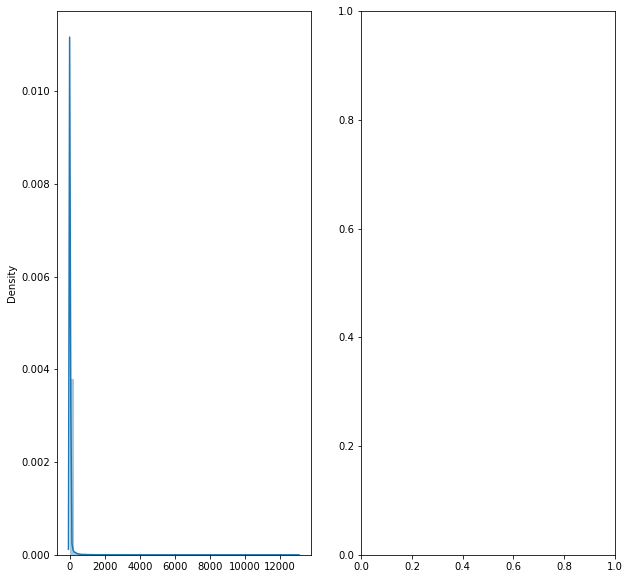

In [480]:
corpus_count = pd.DataFrame(regdf_docterm.sum(axis=0))
# corpus_count.sort_values(ascending=False)[:30]
fig, axes = plt.subplots(1,2, figsize=(10,10))

sns.distplot(corpus_count, ax=axes[0], kde=True)
sns.distplot(corpus_count.sort_values(ascending=False)[-470:], ax=axes[1], kde=True)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

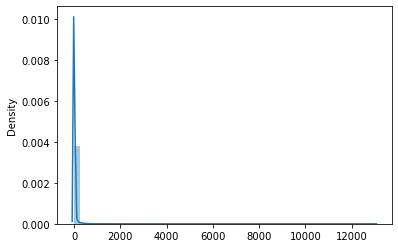

In [448]:
corpus_count_agg = aggdf_docterm.sum(axis=0)
sns.distplot(corpus_count_agg, kde=True)

In [479]:
corpus_count.sort_values(ascending=False)[-470:]

AttributeError: 'matrix' object has no attribute 'sort_values'

### NMF

In [20]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
#     # Apply preprocessor, vectorizer, and topic modeler.
#     if preprocessor is not None:
#         docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [792]:
cv_nmf = CountVectorizer(stop_words='english', max_df=0.1, max_features=500, token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
dt_nmf = cv_nmf.fit_transform(df.tokens.values)

tfidf_nmf = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=2, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf_nmf = tfidf_nmf.fit_transform(df.tokens.values)

corpus1 = np.array(df.tokens)
nmf = NMF(5)
make_topics(corpus1, cv_nmf, nmf, print_n_words=12)

Topic 0:
 GOD, REAL, ASS, KILL, RAP, HOE, DIE, PISTOL, BLACK, BIG, GAME, HARD 

Topic 1:
 COOL, HEY, SHORTIE, BLUE, CAT, PLAY, DIAMOND, YES, NEW, RICH, FRIEND, HEAR 

Topic 2:
 DROP, GIRL, ASS, SET, SWITCH, STOP, DAMN, SPOT, WALK, POP, WATCH, COCK 

Topic 3:
 HOLD, LITTLE, SIT, LONG, WIN, STRONG, BIG, ROLL, LIGHT, COCK, HAND, WAIT 

Topic 4:
 BOY, FAMILY, GIRL, CAR, WALK, FATHER, POP, BLACK, START, WHITE, PEOPLE, CUT 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.14391193, 0.00244141, 0.        , 0.        , 0.        ],
       [0.04231016, 0.01646969, 0.00237085, 0.        , 0.01307944],
       [0.10283591, 0.0043066 , 0.0976345 , 0.        , 0.03345828],
       ...,
       [0.03325085, 0.00708896, 0.        , 0.        , 0.00072015],
       [0.07620557, 0.13104517, 0.01539994, 0.        , 0.01501297],
       [0.05831819, 0.01621264, 0.        , 0.        , 0.00439484]])

In [798]:
nmf_doc_topic = nmf.fit_transform(dt_nmf)

H = pd.DataFrame(nmf_doc_topic.round(5),
             index = ex_label,
             columns = [1,2,3,4,5])
H.sort_values(by=3, ascending=False)[:15]

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


,1,2,3,4,5
"Drop girl drop,Drop to the drop, drop to the drop, drop, drop girl, drop,Drop to the drop, drop to t...",0.00000,0.00000,5.12858,0.00000,0.00000
"Gangsta Shit!,Drop girl,Drop to the drop, drop to the drop, drop, drop girl, drop,Drop to the drop, ...",0.00000,0.00000,4.92337,0.00000,0.00000
"Drop girl drop,Drop to the drop, drop to the drop, drop, drop girl, drop,Drop to the drop, drop to t...",0.00000,0.00000,2.56429,0.00000,0.00000
"Drop girl drop,Drop to the drop, drop to the drop, drop, drop girl, drop,Drop to the drop, drop to t...",0.00000,0.00000,2.56429,0.00000,0.00000
"Set 'dat bitch off!,Walk in the spot and I set 'dat bitch off!,Goddamn!,Set 'dat bitch off!,Walk in ...",0.06176,0.00000,1.77565,0.00000,0.06685
"All of that money gon drop,All of that purple gon drop,All of this shit like a drop,Sorry I cannot b...",0.00000,0.00000,1.75231,0.00000,0.00000
"Nothing's impossible,And all you lame niggas show me what not to do,I met a real bad bitch in the cl...",0.08098,0.13798,1.50520,0.00000,0.00000
"Nothing's impossible,And all you lame niggas show me what not to do,I met a real bad bitch in the cl...",0.03743,0.15268,1.37157,0.00000,0.00000
"I walk in that bitch and the money get tossed,Came in that bitch like a boss,All of that money gon d...",0.00000,0.00000,1.13698,0.00000,0.00000
"Anticipating rain, I can't make the same mistakes again,Them 90s niggas raped the game,And left us w...",0.22524,0.06667,0.71774,0.02214,0.00000


In [774]:
H.sort_values(by=[1], ascending=False)

,1,2,3,4,5,6
"You can't live your life on a bus...,EXT. CHURCH PARKING LOT - DAY,A white bus opens its door and a ...",1.99220,0.0,0.05740,0.0000,0.04882,0.00000
",Yo son you better watch these little fast-ass,Little fancy-pants bitches with the thongs,Heh, that'...",1.50258,0.0,0.26714,0.0000,0.68872,0.19703
"Goddamn, Goddamn, Goddamn,Yo it's kinda hard not to like, get fucking cheesy on this shit,But, does ...",1.34422,0.0,0.00829,0.0000,0.00000,0.04104
"Notorious,My warriors,Be glorious,Twenty-eight, Twenty two, now stories up,So keep my dick up out yo...",1.26989,0.0,0.06807,0.1126,0.34794,0.18989
"Tell me, what am I doing here?,Tell me, what am I doing here?,Tell me, what am I, what am I doing? M...",1.07744,0.0,0.05452,0.0000,0.23196,0.06999
...,...,...,...,...,...,...
Niggas Can't C Me...,0.00000,0.0,0.00000,0.0000,0.00000,0.00000
"Which way did he go George,Which way did he go,Which way did he go,Which way did he go...",0.00000,0.0,0.00000,0.0000,0.00000,0.00000
(Ohhhhhh....)...,0.00000,0.0,0.00000,0.0000,0.00000,0.00000
"(Ohhhhhhhh, heeeeyyy, ohhhhh nooo noooo noooooo)...",0.00000,0.0,0.00000,0.0000,0.00000,0.00000


### Rinse & Repeat - LDA+NMF with aggressively reduced bag of words

In [436]:
cvagg = CountVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features = 500, token_pattern = r'\b[a-z\-A-Z]{3,}\b')
dtagg = cvagg.fit_transform(dfagg.tokens.values)
df_dtfagg = pd.DataFrame(dtagg.toarray(), index=ex_label, columns=cvagg.get_feature_names())
ldaagg = LatentDirichletAllocation(n_components=20, random_state=0)
ldaagg.fit(dt)
pyLDAvis.sklearn.prepare(ldaagg, dtagg, cvagg)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
8     -0.054689 -0.044642       1        1  9.779603
15     0.048238 -0.025826       2        1  7.838815
3      0.019482  0.023473       3        1  7.016371
13     0.170072 -0.005107       4        1  6.744494
12    -0.008097  0.163084       5        1  6.286726
14     0.030384 -0.119552       6        1  6.158709
5      0.135505 -0.020486       7        1  6.016336
9     -0.003332  0.192290       8        1  4.985032
0      0.120862 -0.035103       9        1  4.700914
7     -0.039873  0.040868      10        1  4.664299
17    -0.002063 -0.006267      11        1  4.524179
18     0.100446  0.007129      12        1  4.390432
6      0.080233 -0.083078      13        1  4.137717
11    -0.114778 -0.117825      14        1  3.740205
16    -0.066964 -0.056038      15        1  3.728818
1      0.030765  0.074479      16        1  3.434730
2     -0.096921 -0.046742      17        1  3.317240
10    -0.373572 -0.042969      18        1  2.962790
4      0.062907 -0.165563      19        1  2.819425
19    -0.038604  0.267876      20        1  2.753164, topic_info=        Term        Freq       Total Category  logprob  loglift
10      away  778.000000  778.000000  Default  30.0000  30.0000
172     gang  745.000000  745.000000  Default  29.0000  29.0000
63     check  690.000000  690.000000  Default  28.0000  28.0000
279     nike  641.000000  641.000000  Default  27.0000  27.0000
249     mami  796.000000  796.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
23       bit   13.851961  158.293993  Topic20  -5.7801   1.1564
460  trouble   30.788754  375.258645  Topic20  -4.9813   1.0920
30     blood   23.929206  314.973170  Topic20  -5.2334   1.0150
412    stack   31.640165  579.956122  Topic20  -4.9541   0.6839
70      city   22.926635  654.687271  Topic20  -5.2762   0.2406

[777 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.135024   act
0         3  0.035611   act
0         4  0.080124   act
0         5  0.010386   act
0         6  0.008903   act
...     ...       ...   ...
498       5  0.002761   yes
498      13  0.002761   yes
498      17  0.080076   yes
498      20  0.867034   yes
499      14  0.995513  york

[5004 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 16, 4, 14, 13, 15, 6, 10, 1, 8, 18, 19, 7, 12, 17, 2, 3, 11, 5, 20])

In [437]:
tfidfagg = TfidfVectorizer(stop_words='english', max_df=0.05, min_df=0.0001, max_features=1000, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idfagg = tfidfagg.fit_transform(dfagg.tokens.values)
df_idfagg = pd.DataFrame(dt_idfagg.toarray(), index=ex_label, columns=tfidfagg.get_feature_names())
lda_idfagg = LatentDirichletAllocation(n_components=20, random_state=0)
lda_idfagg.fit(dt_idfagg)
pyLDAvis.sklearn.prepare(lda_idfagg, dt_idfagg, tfidfagg)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.002752 -0.023818       1        1  24.058777
14     0.017239 -0.017736       2        1  21.113362
5      0.022593 -0.001910       3        1  10.696296
9      0.032759  0.000316       4        1   5.979766
2      0.069062  0.017516       5        1   3.607661
17    -0.272182 -0.001915       6        1   2.722372
19     0.122217  0.033749       7        1   2.691806
11    -0.001951 -0.011506       8        1   2.579755
16     0.028333  0.019308       9        1   2.560069
3      0.000960  0.281409      10        1   2.549673
0      0.161503 -0.021348      11        1   2.514791
8      0.017650 -0.086616      12        1   2.257499
18     0.070384 -0.027390      13        1   2.180214
12    -0.098810  0.014482      14        1   2.178875
10    -0.141166 -0.066299      15        1   2.106217
6      0.039062  0.111048      16        1   2.099101
4      0.029718 -0.116691      17        1   2.088822
13    -0.103006  0.061777      18        1   2.048465
1     -0.003091  0.004512      19        1   2.005586
15     0.011480 -0.168887      20        1   1.960893, topic_info=             Term        Freq       Total Category  logprob  loglift
888          thug  130.000000  130.000000  Default  30.0000  30.0000
566  notoriousbig   94.000000   94.000000  Default  29.0000  29.0000
28           away  134.000000  134.000000  Default  28.0000  28.0000
13        alright   93.000000   93.000000  Default  27.0000  27.0000
980          woah   71.000000   71.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
402         honey    5.792138   29.902973  Topic20  -4.8109   2.2903
912         trick    6.574864   50.122938  Topic20  -4.6841   1.9005
348          gang    7.667214  119.918741  Topic20  -4.5304   1.1819
403          hood    7.013358   85.120383  Topic20  -4.6196   1.4355
964         white    7.000035   89.917169  Topic20  -4.6215   1.3788

[869 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.277495   act
0         2  0.170766   act
0         3  0.138747   act
0         4  0.042692   act
0         5  0.010673   act
...     ...       ...   ...
999       4  0.077181  zone
999       7  0.192954  zone
999      11  0.115772  zone
999      13  0.077181  zone
999      17  0.038591  zone

[5283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 15, 6, 10, 3, 18, 20, 12, 17, 4, 1, 9, 19, 13, 11, 7, 5, 14, 2, 16])

In [818]:
cv_nmfagg = CountVectorizer(stop_words='english', max_df=0.2, max_features=1000, token_pattern = r'\b[a-zA-Z]{3,}\b') #removes tokens with less than 3 letters
dt_nmfagg = cv_nmfagg.fit_transform(dfagg.tokens.values)
corpus1agg = np.array(dfagg.tokens)
nmfagg = NMF(6)
make_topics(corpus1agg, cv_nmfagg, nmfagg, print_n_words=10)

Topic 0:
 TELL, TIME, FEEL, LET, LIFE, THINK, LOOK, TRY, BOY, GOD 

Topic 1:
 MAN, FUCKING, THANK, KILL, RIGHT, BLACK, MOTHERFUCKE, SHOUT, REAL, DONALD 

Topic 2:
 LOVE, LET, WAY, RIGHT, GIRL, BABY, FEEL, DAY, HATE, WORD 

Topic 3:
 MONEY, HOE, MARIJUANA, COOCHIE, DRUG, ASS, DAMN, CHASE, LET, PISTOL 

Topic 4:
 MARY, MARIJUANA, THANG, ASS, TIME, HEAR, DOOR, HAPPY, HEAD, NEED 

Topic 5:
 COOL, HEY, NEED, LOOK, SHORTIE, BLUE, CAT, BABY, PLAY, NEW 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[1.34964953e-01, 0.00000000e+00, 8.39084548e-03, 1.29458522e-02,
        0.00000000e+00, 0.00000000e+00],
       [5.73421054e-02, 0.00000000e+00, 1.14919438e-03, 0.00000000e+00,
        2.12297373e-03, 1.41235307e-02],
       [8.40185925e-02, 0.00000000e+00, 1.70188200e-01, 1.24268263e-02,
        0.00000000e+00, 5.37400536e-02],
       ...,
       [3.15955314e-02, 0.00000000e+00, 1.08021246e-02, 0.00000000e+00,
        1.37019381e-03, 0.00000000e+00],
       [5.53880103e-02, 7.38351796e-05, 2.86564812e-03, 3.03099359e-03,
        0.00000000e+00, 1.24113204e-01],
       [5.91331380e-02, 0.00000000e+00, 2.08920660e-02, 0.00000000e+00,
        2.26790213e-03, 0.00000000e+00]])

In [439]:
tfidf_nmfagg = TfidfVectorizer(stop_words='english', max_df=0.2, min_df=2, token_pattern = r'\b[a-zA-Z]{3,}\b')
dt_idf_nmfagg = tfidf_nmfagg.fit_transform(dfagg.tokens.values)
corpus2agg = np.array(dfagg.tokens)
make_topics(corpus2agg, cv_nmfagg, nmfagg, print_n_words=10)

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Topic 0:
 TELL, TIME, LET, LIFE, TRY, THINK, LIVE, LOOK, GOD, TALK 

Topic 1:
 COOL, HEY, THROWDOWN, NEED, LOOK, SUNNY, SHORTIE, KITTY, BLUE, CAT 

Topic 2:
 MAN, FUCKING, THANK, KILL, RIGHT, BLACK, MOTHERFUCKE, SHOUT, REAL, BIG 

Topic 3:
 MONEY, FETTI, MARIJUANA, DENIRO, HOE, COOCHIE, DRUG, CHASE, DAMN, NIKE 

Topic 4:
 LOVE, LET, GIRL, WAY, DAY, BABY, WORD, HATE, RIGHT, NIGHT 

Topic 5:
 MARY, MARIJUANA, THANG, ASS, TIME, HEAR, DOOR, HAPPY, HEAD, NEED 

Topic 6:
 BOY, DONALD, FAMILY, GIRL, LOOK, WALK, DAY, MARCUS, CUT, SWANK 

Topic 7:
 DROP, GIRL, ASS, VROOM, SCREECH, SET, HIT, DAT, SWITCH, STOP 

Topic 8:
 MUSIC, STUDIO, RECORD, USE, COURTESY, ASCAP, WEST, RIGHT, MIX, PUBLISH 

Topic 9:
 FEEL, BAM, REAL, FEELING, WAY, REALLY, LOOK, GOOD, THINK, THING 



/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0.1405246 , 0.        , 0.        , ..., 0.        , 0.04314326,
        0.        ],
       [0.01320831, 0.01065501, 0.        , ..., 0.00414655, 0.        ,
        0.15937478],
       [0.08349607, 0.03143823, 0.        , ..., 0.09733433, 0.00621601,
        0.        ],
       ...,
       [0.02837942, 0.        , 0.        , ..., 0.        , 0.02431766,
        0.        ],
       [0.05504656, 0.09066121, 0.        , ..., 0.01763058, 0.03472435,
        0.        ],
       [0.05185696, 0.        , 0.        , ..., 0.        , 0.04949061,
        0.        ]])

### CorEx - no anchor, original df

In [320]:
!pip install corextopic
!pip install networkx

     |████████████████████████████████| 1.9 MB 2.3 MB/s            


In [321]:
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [519]:
words = list(np.asarray(cv_nmf.get_feature_names()))

In [520]:
ce_model = ct.Corex(n_hidden=6, words=words, seed=1)
ce_model.fit(dt_nmf, words=words, docs=df.tokens)

In [511]:
len(words)

13869

In [512]:
dt_nmf.shape

(11510, 24485)

In [516]:
len(df.tokens)

11510

In [ ]:
# Print all topics from the CorEx topic model
topics = ce_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [ ]:
ce_model.get_top_docs(topic=1, n_docs=2)

In [ ]:
predictions = pd.DataFrame(ce_model.predict(dt_nmf), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)
# predictions = pd.DataFrame(ce_model.labels, columns=['topic'+str(i) for i in range(6)])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(ce_model.tcs.shape[0]), ce_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [508]:
dt_nmfagg

<11510x13872 sparse matrix of type '<class 'numpy.int64'>'
	with 391619 stored elements in Compressed Sparse Row format>

### CorEx with anchor on aggressive df

In [852]:
words_agg = list(np.asarray(cv_nmfagg.get_feature_names()))

anchor_model_agg = ct.Corex(n_hidden=6, words=words_agg,
                       max_iter=200, verbose=False, seed=1)

anchor_model_agg.fit(dt_nmfagg, words=words_agg, docs=dfagg.tokens, 
                anchors=[['music'], 
                         ['drug'], 
                         ['white'],
                         ], anchor_strength=4)

# Print all topics from the CorEx topic model
topics = anchor_model_agg.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0: music,life,think,time,feel,god,live,way,day,let
1: drug,pistol,money,hit,ass,smoke,hoe,fucking,blow,pop
2: white,look,man,try,black,use,little,girl,big,kid
3: tell,leave,face,mama,kill,need,rifle,hate,pay,eye
4: bullshit,run,new,street,watch,sell,walk,hell,stay,hand
5: rap,game,play,break,got,talk,real,doctor,flow,hard


In [857]:
index = []
for i in range(0,10):
    index.append(anchor_model_agg.get_top_docs(topic=4, n_docs=10, print_docs=False)[i][0])
    
df.iloc[index[5:]]

artist  \
11497  Childish Gambino   
6648     Montana of 300   
6646     Montana of 300   
1784     Kendrick Lamar   
4526             Common   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [845]:
predictions = pd.DataFrame(anchor_model_agg.labels, columns=['topic'+str(i) for i in range(6)])
predictions

,topic0,topic1,topic2,topic3,topic4,topic5
0,True,True,False,False,True,True
1,False,False,False,False,False,False
2,True,True,False,True,True,True
3,False,False,False,False,False,False
4,True,False,False,False,True,False
...,...,...,...,...,...,...
11505,False,False,False,False,False,False
11506,True,True,False,True,True,True
11507,False,False,False,False,False,False
11508,True,False,False,False,False,True


In [543]:
pd.DataFrame(anchor_model_agg.p_y_given_x, columns=['topic'+str(i) for i in range(12)])

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11
0,0.642121,0.999999,0.999999,0.999999,0.001668,0.001164,0.999999,0.004029,0.999999,0.005354,0.999949,0.228461
1,0.004748,0.000754,0.000919,0.247102,0.000158,0.001045,0.019254,0.036553,0.000280,0.008509,0.002285,0.002774
2,0.999999,0.003535,0.021220,0.999999,0.999999,0.999999,0.999999,0.999999,0.999952,0.999999,0.999490,0.050280
3,0.004748,0.000754,0.000919,0.247102,0.000158,0.001045,0.019254,0.036553,0.000280,0.008509,0.002285,0.002774
4,0.999999,0.000791,0.001081,0.193481,0.000163,0.001120,0.999999,0.972190,0.433313,0.011705,0.004624,0.035291
...,...,...,...,...,...,...,...,...,...,...,...,...
11505,0.000422,0.000753,0.008438,0.000031,0.000158,0.001049,0.010297,0.009890,0.268702,0.011115,0.004132,0.002755
11506,0.006016,0.999999,0.999997,0.999999,0.001211,0.005851,0.999935,0.999886,0.341696,0.999920,0.999999,0.999999
11507,0.000421,0.000756,0.000959,0.000031,0.000158,0.001049,0.009964,0.013843,0.306708,0.000909,0.000001,0.002745
11508,0.000939,0.012455,0.000976,0.999999,0.000180,0.006153,0.243709,0.003644,0.898859,0.005652,0.033388,0.999999


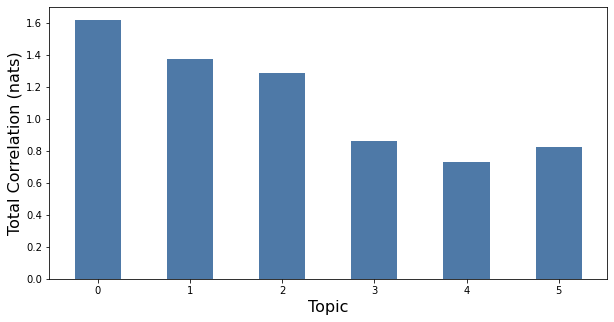

In [838]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(anchor_model_agg.tcs.shape[0]), anchor_model_agg.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

array([1.48860865, 1.32072537, 1.62045226, 1.85159693, 1.03432148,
       1.20771957, 1.23880259, 1.18085049, 1.44592116, 0.86656177])

### Dictionary building for manual normalization

In [ ]:
list_for_dict = []

for doc in spacyd: 
    for w in doc:
        if w.pos_ == "PROPN":
            list_for_dict.append(str(w).lower())

output = set(list_for_dict)
print(len(list_for_dict))
print(len(output))
outputdf = pd.DataFrame(output)

outputdf.to_csv("output.csv")

### K-means Doc-Topic clustering

In [732]:
from sklearn.cluster import KMeans
#K=6
doc_topic = nmf.fit_transform(dt_nmf)
df_doc_topics = pd.DataFrame(doc_topic)
# Convert DataFrame to matrix
mat = df_doc_topics.values

km = KMeans(n_clusters=6, random_state=10)
km.fit(mat)

# Get cluster assignment labels
df_doc_topic_clusters = df_doc_topics.copy()
df_doc_topic_clusters['Cluster']=km.labels_
df_doc_topic_clusters['Cluster'].value_counts()

/opt/anaconda3/envs/nlpenv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


0    8570
5    2838
2      99
3       1
1       1
4       1
Name: Cluster, dtype: int64

### DBSCAN Doc-Topic clustering

In [750]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=4).fit(df_doc_topics)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
set(labels)

{-1, 0}

In [735]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

4

In [736]:
db_doctopic = df_doc_topics[class_member_mask & core_samples_mask]

In [737]:
db_doctopic

,0,1,2,3,4
0,0.132893,0.001310,0.000000,0.015133,0.000000
1,0.056857,0.007804,0.000000,0.000000,0.002330
2,0.080981,0.150250,0.000000,0.015114,0.000000
3,0.056857,0.007804,0.000000,0.000000,0.002330
4,0.140696,0.132896,0.000000,0.000000,0.000000
...,...,...,...,...,...
11505,0.049961,0.123702,0.005284,0.006495,0.014835
11506,0.125858,0.012186,0.083519,0.002317,0.000000
11507,0.026130,0.007350,0.000000,0.000000,0.002501
11508,0.082031,0.055498,0.000000,0.000000,0.000000


In [738]:
df_outcome = pd.merge(db_doctopic, dfagg, how="left", left_on=db_doctopic.index, right_on=dfagg.index).drop(columns=["cleaned", "english_check","tokens","lyrics","placeholder","ph_hyph"], axis=1).iloc[:,1:]
df_outcome

,0,1,2,3,4,artist
0,0.132893,0.001310,0.000000,0.015133,0.000000,Talib Kweli
1,0.056857,0.007804,0.000000,0.000000,0.002330,Talib Kweli
2,0.080981,0.150250,0.000000,0.015114,0.000000,Talib Kweli
3,0.056857,0.007804,0.000000,0.000000,0.002330,Talib Kweli
4,0.140696,0.132896,0.000000,0.000000,0.000000,Talib Kweli
...,...,...,...,...,...,...
11384,0.049961,0.123702,0.005284,0.006495,0.014835,Childish Gambino
11385,0.125858,0.012186,0.083519,0.002317,0.000000,Childish Gambino
11386,0.026130,0.007350,0.000000,0.000000,0.002501,Childish Gambino
11387,0.082031,0.055498,0.000000,0.000000,0.000000,Childish Gambino


In [739]:
db_wtarget = db_doctopic.copy()
db_wtarget["target"] = db_wtarget.idxmax(axis="columns")
db_wtarget

,0,1,2,3,4,target
0,0.132893,0.001310,0.000000,0.015133,0.000000,0
1,0.056857,0.007804,0.000000,0.000000,0.002330,0
2,0.080981,0.150250,0.000000,0.015114,0.000000,1
3,0.056857,0.007804,0.000000,0.000000,0.002330,0
4,0.140696,0.132896,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...
11505,0.049961,0.123702,0.005284,0.006495,0.014835,1
11506,0.125858,0.012186,0.083519,0.002317,0.000000,0
11507,0.026130,0.007350,0.000000,0.000000,0.002501,0
11508,0.082031,0.055498,0.000000,0.000000,0.000000,0


In [744]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(db_wtarget.iloc[:,:-1])
pcafeatures_train = pca.transform(db_wtarget.iloc[:,:-1])

In [745]:
topic_target = set(db_wtarget.target.values)

In [746]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y', 'w'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

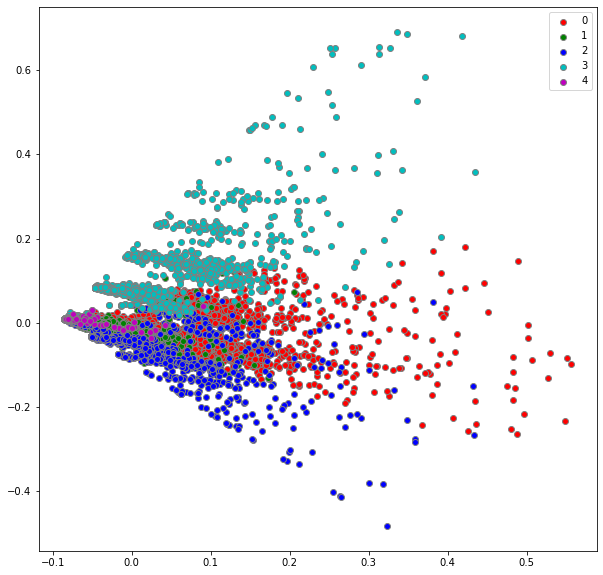

In [747]:
plot_PCA_2D(pcafeatures_train, target=db_wtarget.target, target_names=topic_target)


### K-Means cluster interpretation

In [603]:
from sklearn.metrics import pairwise_distances

top_3_docs = pairwise_distances([[num[0] for num in df_clusters.iloc[1].values.reshape(-1, 1).tolist()]], \
                                df_doc_topics,metric='euclidean').argsort()[0, :3]
df['Cluster']=km.labels_

In [604]:
df.iloc[top_3_docs[0]]

artist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [626]:
df_doc_topics.iloc[top_3_docs[0]]

0    0.303072
1    0.012249
2    0.093107
3    0.541078
4    0.001380
5    0.000000
Name: 7913, dtype: float64

In [644]:
df[df.Cluster==0].groupby(['Cluster', 'artist']).count().sort_values(by="tokens",ascending=False).iloc[:,:1]

lyrics
Cluster artist                    
0       Tupac2                1309
        Tupac1                 669
        Kanye West             352
        Tyler The Creator      344
        Eazy-E                 338
        Kendrick Lamar         337
        The Notorious BIG      335
        Eminem                 308
        Jay-z                  304
        Nas                    304
        Lil Wayne              284
        Lupe Fiasco            282
        J Cole                 280
        Logic                  276
        Joey Badass            275
        Ice Cube               258
        ASAP Rocky             254
        Chance The Rapper      251
        Royce Da 59            244
        NF                     240
        Common                 236
        Mac Miller             234
        Pusha-T                226
        Childish Gambino       225
        Wu-Tang Clan           215
        CunninLynguists        215
        Immortal Technique     206
        Talib Kweli            203
        Big L                  199
        Bas                    187
        Action Bronson         187
        Isaiah Rashad          173
        Drake                  162
        Scarface               162
        Deniro Farrar          146
        Earl Sweatshirt        115
        Montana of 300         111
        ASAP Ant                68
        Andre 3000              21

In [687]:
pd.options.display.max_rows = 200
df.groupby(["Cluster","artist"]).count()

lyrics  cleaned  english_check  placeholder  \
Cluster artist                                                            
0       ASAP Ant                68       68             68           68   
        ASAP Rocky             254      254            254          254   
        Action Bronson         187      187            187          187   
        Andre 3000              21       21             21           21   
        Bas                    187      187            187          187   
        Big L                  199      199            199          199   
        Chance The Rapper      251      251            251          251   
        Childish Gambino       225      225            225          225   
        Common                 236      236            236          236   
        CunninLynguists        215      215            215          215   
        Deniro Farrar          146      146            146          146   
        Drake                  162      162            162          162   
        Earl Sweatshirt        115      115            115          115   
        Eazy-E                 338      338            338          338   
        Eminem                 308      308            308          308   
        Ice Cube               258      257            258          258   
        Immortal Technique     206      206            206          206   
        Isaiah Rashad          173      173            173          173   
        J Cole                 280      280            280          280   
        Jay-z                  304      304            304          304   
        Joey Badass            275      275            275          275   
        Kanye West             352      352            352          352   
        Kendrick Lamar         337      337            337          337   
        Lil Wayne              284      284            284          284   
        Logic                  276      276            276          276   
        Lupe Fiasco            282      282            282          282   
        Mac Miller             234      234            234          234   
        Montana of 300         111      111            111          111   
        NF                     240      240            240          240   
        Nas                    304      304            304          304   
        Pusha-T                226      226            226          226   
        Royce Da 59            244      244            244          244   
        Scarface               162      162            162          162   
        Talib Kweli            203      203            203          203   
        The Notorious BIG      335      335            335          335   
        Tupac1                 669      669            669          669   
        Tupac2                1309     1309           1309         1309   
        Tyler The Creator      344      344            344          344   
        Wu-Tang Clan           215      215            215          215   
1       Scarface                 1        1              1            1   
2       Andre 3000               1        1              1            1   
3       J Cole                   1        1              1            1   
4       ASAP Ant                17       17             17           17   
        ASAP Rocky               8        8              8            8   
        Action Bronson           4        4              4            4   
        Bas                      8        8              8            8   
        Big L                   25       25             25           25   
        Chance The Rapper        5        5              5            5   
        Childish Gambino        16       16             16           16   
        Common                   1        1              1            1   
        CunninLynguists          3        3              3            3   
        Deniro Farrar           14       14          

### DBSCAN Clustering interpretation (cont'd)

In [740]:
db_doctopic

,0,1,2,3,4
0,0.132893,0.001310,0.000000,0.015133,0.000000
1,0.056857,0.007804,0.000000,0.000000,0.002330
2,0.080981,0.150250,0.000000,0.015114,0.000000
3,0.056857,0.007804,0.000000,0.000000,0.002330
4,0.140696,0.132896,0.000000,0.000000,0.000000
...,...,...,...,...,...
11505,0.049961,0.123702,0.005284,0.006495,0.014835
11506,0.125858,0.012186,0.083519,0.002317,0.000000
11507,0.026130,0.007350,0.000000,0.000000,0.002501
11508,0.082031,0.055498,0.000000,0.000000,0.000000


In [741]:
db_doctopic_clusters = db_doctopic.copy()
db_doctopic_clusters['Cluster']=db_wtarget.iloc[:,-1:]
db_doctopic_clusters['Cluster'].value_counts()


0    7961
1    1115
3    1113
2    1103
4      97
Name: Cluster, dtype: int64

In [742]:
db_clusters = db_doctopic_clusters.groupby(['Cluster']).median()
db_clusters

,0,1,2,3,4
Cluster,,,,,
0,0.067978,0.001035,0.00000,0.000378,0.000000
1,0.026732,0.094682,0.00097,0.000252,0.000230
2,0.048950,0.000000,0.10463,0.000534,0.000000
3,0.061356,0.000206,0.00000,0.110522,0.000000
4,0.006172,0.000000,0.00000,0.000670,0.012639


In [743]:
def db_returntop3 (n):
    return pairwise_distances([[num[0] for num in db_clusters.iloc[n].values.reshape(-1, 1).tolist()]], \
                                    db_doctopic,metric='euclidean').argsort()[0, :3]

In [713]:
for i in db_returntop3(1):
    print(df.iloc[i])

artist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Big L
lyrics           I should never rhyme cause every time I step into a contest,Kids evacuate the premises like it's a bomb th

In [715]:
len(core_samples_mask)

11510

In [716]:
len(class_member_mask)

11510